In [241]:
%matplotlib inline

import cv2
import json
import tensorflow as tf
import numpy as np

from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [257]:
labels = json.load(open('../data/label.json', 'r'))
labels = [labels[str(idx)] for idx in labels]

In [231]:
img_path = '../data/images'

images = []
# for f in listdir(img_path):
#     if isfile(join(img_path, f)):
for f in labels:
    img_name = labels[str(f)]['label']
    img = cv2.imread('{}/{}_{}.jpg'.format(img_path, f, img_name), cv2.IMREAD_GRAYSCALE)
#         img = cv2.imread(join(img_path, f), cv2.IMREAD_GRAYSCALE)
#         plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    images.append(img)

In [467]:
def create_sparse(batch_size, images, labels, dtype=np.int64):
    indices = []
    values = []
#     seq_length = []
    
    sample_index = np.random.choice(len(images) - 1, size=batch_size)
    sample_images = []
    
    x_max = 0
    y_max = 0

    for key, index in zip(sample_index, range(batch_size)):
        sample = labels[key]
        length = sample['length']
        label = sample['label']
        
        img = images[key]
#         plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        x_max = max(x_max, img.shape[0])
        y_max = max(y_max, img.shape[1])

#         seq_length.append(length)
        sample_images.append(img)

        for number, number_index in zip(label, range(length)):
            indices.append((index, number_index))
            values.append(ord(str(number)))

    indices = np.array(indices, dtype=np.int64)
    values = np.array(values, dtype=dtype)
    shape = np.array([batch_size, np.asarray(indices).max(0)[1] + 1], dtype=np.int64)
    seq_length = np.ones(batch_size) * np.asarray(indices).max(0)[1] + 1
#     shape = np.array([batch_size, seq_length], np.int64)

    return indices, values, shape, sample_images, seq_length, x_max, y_max

# create_sparse(n_batch_size, images, labels)

In [477]:
def add_padding_to_images(x_max, y_max, images):

    output = []
    for img in images:
        left_pad = int((x_max - img.shape[0]) / 2)
        right_pad = x_max - img.shape[0] - int((x_max - img.shape[0]) / 2)
        top_pad = int((y_max - img.shape[1]) / 2)
        bottom_pad = y_max - img.shape[1] - int((y_max - img.shape[1]) / 2)

        img = np.pad(img, 
                     pad_width=((left_pad, right_pad), 
                                (top_pad, bottom_pad)), 
                     mode='constant', 
                     constant_values=0)
        
        img = np.transpose(img.reshape((x_max, y_max)))
        output.append(img)
        
    return np.array(output)

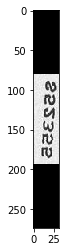

In [489]:
plt.imshow(sample_images[0], cmap='gray', vmin=0, vmax=255)

In [479]:
n_batch_size = 32
n_features = 32
n_rnn_layers = 2
n_hidden = 64
n_classes = ord('z') - ord('a') + 10 + 1 + 1 + 1

n_epochs = 100

learning_rate = 0.001

In [480]:
n_test_size = 0.3
n_test_index = int(len(images) * n_test_size)

train_images = images[:n_test_index]
test_images = images[n_test_index:]

train_labels = labels[:n_test_index]
test_labels = labels[n_test_index:]

In [491]:
graph = tf.Graph()

with graph.as_default():
    inputs = tf.placeholder(tf.float32, [None, None, n_features])
    targets = tf.sparse_placeholder(tf.int32)
    seq_len = tf.placeholder(tf.int32, [None])
    
    cells = []
    for _ in range(n_rnn_layers):
        cell = tf.contrib.rnn.LSTMCell(n_hidden)
        cells.append(cell)
        
    stack = tf.contrib.rnn.MultiRNNCell(cells)

    outputs, _ = tf.nn.dynamic_rnn(stack, inputs, seq_len, dtype=tf.float32)
    
    outputs = tf.reshape(outputs, [-1, n_hidden])
    
    W = tf.Variable(tf.truncated_normal([n_hidden,
                                         n_classes],
                                        stddev=0.1))
    b = tf.Variable(tf.constant(0., shape=[n_classes]))
    
    logits = tf.matmul(outputs, W) + b
    logits = tf.reshape(logits, [n_batch_size, -1, n_classes])
    logits = tf.transpose(logits, (1, 0, 2))
    
    loss = tf.nn.ctc_loss(labels=targets, inputs=logits, sequence_length=seq_len)
    cost = tf.reduce_mean(loss)

    optimizer = tf.train.AdamOptimizer(learning_rate,
                                           0.9).minimize(cost)
    
#     decoded, log_prob = tf.nn.ctc_greedy_decoder(logits, seq_len)
    decoded, log_prob = tf.nn.ctc_beam_search_decoder(logits, seq_len, merge_repeated=False)
    
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),
                                          targets))

In [492]:
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(50):
        train_cost = train_ler = 0
        
        indices, values, shape, sample_images, seq_length, x_max, y_max = create_sparse(n_batch_size, train_images, train_labels)
        sample_images = add_padding_to_images(x_max, y_max, sample_images)
#         sample_images = np.transpose(sample_images, (0, 2, 1))
        train_targets = tf.SparseTensorValue(indices=indices, values=values, dense_shape=shape)
            
        feed = {
            inputs: sample_images,
            targets: train_targets,
            seq_len: seq_length,
        }
        
        batch_cost, _ = sess.run([cost, optimizer], feed_dict=feed)
        train_cost += batch_cost * n_batch_size
        train_ler += sess.run(ler, feed_dict=feed) * n_batch_size
        
        log = 'Epoch {}, train_cost: {:.3f}, train_ler: {:.3f}, val_cost: {:.3f}, val_ler: {:.3f}'
        print(log.format(epoch, train_cost, train_ler, 0, 0))
        
    decoded_values = sess.run(decoded[0], feed_dict=feed)

Epoch 0, train_cost: 1737.506, train_ler: 32.700, val_cost: 0.000, val_ler: 0.000
Epoch 1, train_cost: 1969.367, train_ler: 32.833, val_cost: 0.000, val_ler: 0.000
Epoch 2, train_cost: 1615.827, train_ler: 33.900, val_cost: 0.000, val_ler: 0.000
Epoch 3, train_cost: 1611.220, train_ler: 32.900, val_cost: 0.000, val_ler: 0.000
Epoch 4, train_cost: 1819.304, train_ler: 32.900, val_cost: 0.000, val_ler: 0.000
Epoch 5, train_cost: 1690.739, train_ler: 33.000, val_cost: 0.000, val_ler: 0.000
Epoch 6, train_cost: 1705.490, train_ler: 33.900, val_cost: 0.000, val_ler: 0.000
Epoch 7, train_cost: 2143.520, train_ler: 32.917, val_cost: 0.000, val_ler: 0.000
Epoch 8, train_cost: 1781.228, train_ler: 33.700, val_cost: 0.000, val_ler: 0.000
Epoch 9, train_cost: 1768.645, train_ler: 32.900, val_cost: 0.000, val_ler: 0.000
Epoch 10, train_cost: 1530.641, train_ler: 32.400, val_cost: 0.000, val_ler: 0.000
Epoch 11, train_cost: 1520.222, train_ler: 32.000, val_cost: 0.000, val_ler: 0.000
Epoch 12, trai

In [493]:
str_decoded = ''.join([chr(x) for x in np.asarray(decoded_values[1])])

In [494]:
str_decoded

'\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17\x17'

In [495]:
decoded_values[1]

array([23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23])

In [486]:
values

array([83, 53, 50, 51, 53, 53, 48, 49, 51, 53, 48, 52, 50, 49, 48, 48, 52,
       54, 57, 48, 55, 49, 48, 52, 52, 48, 53, 48, 49, 48, 51, 56, 49, 49,
       51, 48, 49, 56, 49, 48, 57, 53, 53, 49, 48, 52, 56, 53, 51, 49, 50,
       57, 49, 57, 53, 48, 66, 49, 50, 50, 57, 53, 53, 52, 57, 49, 49, 48,
       53, 52, 57, 52, 53, 56, 53, 48, 49, 48, 55, 57, 51, 49, 51, 48, 52,
       53, 51, 49, 53, 53, 52, 54, 53, 49, 57, 48, 57, 49, 53, 52, 56, 53,
       49, 51, 53, 45, 56, 49, 51, 52, 53, 48, 57, 48, 55, 48, 48, 48, 53,
       51, 49, 57, 49, 52, 57, 48, 55, 51, 56, 48, 51, 57, 52, 53, 48, 48,
       53, 54, 51, 49, 56, 48, 49, 53, 45, 49, 50, 57, 52, 57, 48, 55, 50,
       53, 49, 48, 51, 48, 57, 48, 55, 52, 57, 49, 53, 48, 48, 57, 51, 49,
       49, 74, 49, 48, 52, 53, 48, 57, 52, 53, 57, 51, 49, 49, 53, 53, 49,
       53, 55, 48, 48, 52, 53, 57, 51, 52, 49, 49, 53, 53, 57, 48, 55, 54,
       51, 49, 48, 48, 54, 48, 51, 53, 52, 55, 57, 52, 49, 52, 66, 49, 50,
       50, 57, 53, 53, 48